In [65]:
import numpy as np
import pandas as pd
from os import path
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
DATA_DIR = "../../data"

In [3]:
chen_data = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_data.csv"), index_col=0)
chen_data

,Antibody_ID,heavy,light,Y
0,12e8,EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLE...,DIVMTQSQKFMSTSVGDRVSITCKASQNVGTAVAWYQQKPGQSPKL...,0
1,15c8,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0
2,1a0q,EVQLQESDAELVKPGASVKISCKASGYTFTDHVIHWVKQKPEQGLE...,DIELTQSPSSLSASLGGKVTITCKASQDIKKYIGWYQHKPGKQPRL...,1
3,1a14,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,0
4,1a2y,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,0
...,...,...,...,...
2404,6s5a,EVKLLESGGGLVQPGGSLKLSCAASGFDFSRYWMNWVRQAPGKGLE...,QAVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0
2405,6tyb,EVQLVQSGTEVKRPGESLTISCKTSGYSFSGTWISWVRQMPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQGISTYLAWYQQKPGKAPKL...,0
2406,6u1t,EVQLVESGGGLVKPGGSLKLSCAASGFTFSSYDMSWVRQTPEKRLE...,DIQMTQSPASQSASLGESVTITCLASQTIGTWLAWYQQKPGKSPQL...,0
2407,7fab,AVQLEQSGPGLVRPSQTLSLTCTVSGTSFDDYYWTWVRQPPGRGLE...,ASVLTQPPSVSGAPGQRVTISCTGSSSNIGAGHNVKWYQQLPGTAP...,0


# Load precomputed ANARCI matrix

In [6]:
heavy_df = pd.read_csv(path.join(DATA_DIR, "chen/abnumber/chen_heavy_chain_numbering.csv"), index_col=0)
light_df = pd.read_csv(path.join(DATA_DIR, "chen/abnumber/chen_light_chain_numbering.csv"), index_col=0)
heavy_df.head()

,Ab_ID,species,chain_type,1,2,3,3A,4,4A,5,...,119,120,121,122,123,124,125,126,127,128
0,12e8,mouse,H,E,V,Q,-,L,-,Q,...,G,Q,G,T,L,V,T,V,S,A
1,15c8,mouse,H,E,V,Q,-,L,-,Q,...,G,Q,G,T,T,L,T,V,S,S
2,1a0q,mouse,H,E,V,Q,-,L,-,Q,...,G,Q,G,T,T,L,T,V,S,S
3,1a14,mouse,H,Q,V,Q,-,L,-,Q,...,G,Q,G,T,T,V,T,V,-,-
4,1a2y,mouse,H,Q,V,Q,-,L,-,Q,...,G,Q,G,T,T,L,T,V,S,S


In [7]:
[i for i in chen_data.index if i not in heavy_df.index]

[1921, 2097]

In [8]:
heavy_df.loc[1921] = [np.nan] * 207
heavy_df.loc[2097] = [np.nan] * 207

heavy_df.loc[1921]["Ab_ID"] = chen_data.loc[1921]["Antibody_ID"]
heavy_df.loc[2097]["Ab_ID"] = chen_data.loc[2097]["Antibody_ID"]

In [9]:
heavy_df = heavy_df.loc[chen_data.index]
light_df = light_df.loc[chen_data.index]
len(heavy_df)

1551

In [10]:
len(light_df)

1551

In [11]:
def anarci_similarity_matrix(anarci_df):
    pos_columns = [col for col in anarci_df.columns if col[0].isnumeric()]
    positions = anarci_df[pos_columns]
    tasks = [(row, positions) for i, row in positions.iterrows()]
    rows = tqdm(map(identity_task, tasks), total=len(tasks), position=0, leave=True)
    matrix = pd.DataFrame(rows)
    matrix.index = matrix.columns
    return matrix

def identity_task(task):
    seq, seqs = task
    return seqs.apply(all_position_identity, seq2=seq, axis=1).astype(np.float16)

def all_position_identity(seq1, seq2):
    return (seq1 == seq2).mean()

# Compute similarity matrices

In [12]:
heavy_similarity = anarci_similarity_matrix(heavy_df)
heavy_similarity.head()

100%|██████████| 1551/1551 [08:55<00:00,  2.89it/s]


,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.000000,0.857910,0.784180,0.769531,0.656738,0.759766,0.686035,0.686035,0.818848,0.754883,...,0.598145,0.691406,0.745117,0.686035,0.691406,0.710938,0.696289,0.720703,0.691406,0.691406
1,0.857910,1.000000,0.818848,0.789062,0.676270,0.774414,0.681152,0.681152,0.857910,0.784180,...,0.598145,0.696289,0.750000,0.696289,0.706055,0.686035,0.671387,0.715820,0.691406,0.691406
2,0.784180,0.818848,1.000000,0.818848,0.676270,0.813965,0.725586,0.725586,0.793945,0.803711,...,0.583496,0.681152,0.750000,0.691406,0.706055,0.676270,0.676270,0.696289,0.637207,0.666504
3,0.769531,0.789062,0.818848,1.000000,0.656738,0.808594,0.701172,0.701172,0.793945,0.803711,...,0.598145,0.701172,0.759766,0.715820,0.740234,0.671387,0.686035,0.691406,0.656738,0.691406
4,0.656738,0.676270,0.676270,0.656738,1.000000,0.666504,0.686035,0.686035,0.676270,0.701172,...,0.720703,0.725586,0.661621,0.656738,0.656738,0.696289,0.651855,0.706055,0.720703,0.706055


In [13]:
heavy_similarity.to_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity_heavy.csv"))

In [4]:
heavy_similarity = pd.read_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity_heavy.csv"), index_col=0)

In [14]:
light_similarity = anarci_similarity_matrix(light_df)
light_similarity.head()

100%|██████████| 1551/1551 [08:29<00:00,  3.04it/s]


,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.000000,0.695801,0.623047,0.630371,0.645020,0.586914,0.652344,0.652344,0.703125,0.681152,...,0.586914,0.572266,0.558105,0.550781,0.709961,0.500000,0.384033,0.688477,0.528809,0.565430
1,0.695801,1.000000,0.681152,0.681152,0.709961,0.630371,0.630371,0.630371,0.637695,0.811523,...,0.594238,0.608887,0.594238,0.565430,0.681152,0.528809,0.434814,0.717285,0.586914,0.572266
2,0.623047,0.681152,1.000000,0.703125,0.709961,0.565430,0.565430,0.565430,0.623047,0.637695,...,0.536133,0.528809,0.550781,0.550781,0.681152,0.500000,0.434814,0.703125,0.514648,0.550781
3,0.630371,0.681152,0.703125,1.000000,0.666504,0.565430,0.608887,0.608887,0.572266,0.623047,...,0.558105,0.572266,0.558105,0.521973,0.673828,0.514648,0.413086,0.652344,0.507324,0.536133
4,0.645020,0.709961,0.709961,0.666504,1.000000,0.594238,0.594238,0.594238,0.623047,0.666504,...,0.528809,0.558105,0.543457,0.543457,0.703125,0.543457,0.434814,0.818848,0.521973,0.565430


In [15]:
light_similarity.to_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity_light.csv"))

In [5]:
light_similarity = pd.read_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity_light.csv"), index_col=0)


In [16]:
def fit_umap(df, n_components=2, random_state=0, **kwargs):
    reducer = umap.UMAP(n_components=n_components, random_state=random_state, metric='precomputed', **kwargs)
    embedding = reducer.fit_transform(df)
    return reducer, pd.DataFrame(embedding, columns=[f'UMAP-{i+1}' for i in range(n_components)], index=df.index)

In [17]:
def agglomerative_clustering(distance, linkage='complete', **kwargs):
    clusters = AgglomerativeClustering(linkage=linkage, affinity='precomputed', **kwargs).fit(distance).labels_
    return pd.Series(clusters+1, distance.index)

## Combine heavy and light distances

In [18]:
similarity = (light_similarity + heavy_similarity) / 2
similarity

,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.000000,0.776855,0.703613,0.700195,0.650879,0.673340,0.668945,0.668945,0.760742,0.717773,...,0.592773,0.631836,0.651367,0.618164,0.700684,0.605469,0.540039,0.704590,0.610352,0.628418
1,0.776855,1.000000,0.750000,0.735352,0.693359,0.702148,0.655762,0.655762,0.748047,0.797852,...,0.596191,0.652344,0.671875,0.630859,0.693359,0.607422,0.553223,0.716797,0.639160,0.631836
2,0.703613,0.750000,1.000000,0.760742,0.693359,0.689453,0.645508,0.645508,0.708496,0.720703,...,0.559570,0.604980,0.650391,0.621094,0.693359,0.587891,0.555664,0.699707,0.576172,0.608398
3,0.700195,0.735352,0.760742,1.000000,0.661621,0.687012,0.655273,0.655273,0.683105,0.713379,...,0.578125,0.636719,0.659180,0.619141,0.707031,0.592773,0.549805,0.671875,0.582031,0.613770
4,0.650879,0.693359,0.693359,0.661621,1.000000,0.630371,0.640137,0.640137,0.649414,0.683594,...,0.625000,0.641602,0.602539,0.600098,0.679688,0.620117,0.543457,0.762695,0.621094,0.635742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,0.605469,0.607422,0.587891,0.592773,0.620117,0.571289,0.585938,0.582031,0.620117,0.613770,...,0.577148,0.675781,0.645508,0.594238,0.558594,1.000000,0.477051,0.671875,0.594238,0.647949
2405,0.540039,0.553223,0.555664,0.549805,0.543457,0.516113,0.502441,0.502441,0.520508,0.526367,...,0.467041,0.511230,0.524414,0.516113,0.572754,0.477051,1.000000,0.562988,0.481689,0.513672
2406,0.704590,0.716797,0.699707,0.671875,0.762695,0.661133,0.657227,0.657227,0.700195,0.678711,...,0.575684,0.697266,0.623535,0.615234,0.701660,0.671875,0.562988,1.000000,0.594238,0.687012
2407,0.610352,0.639160,0.576172,0.582031,0.621094,0.581055,0.556641,0.556641,0.595703,0.609863,...,0.645996,0.709961,0.696777,0.620605,0.596680,0.594238,0.481689,0.594238,1.000000,0.640137


In [19]:
similarity.to_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity.csv"))

In [4]:
similarity = pd.read_csv(path.join(DATA_DIR, "chen/distances/deduplicated_anarci_similarity.csv"), index_col=0)
similarity.head()

,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.00000,0.77700,0.70350,0.69995,0.65085,0.67350,0.66915,0.66915,0.76100,0.71800,...,0.59250,0.63185,0.65150,0.61850,0.70070,0.60550,0.54015,0.70460,0.61020,0.62840
1,0.77700,1.00000,0.75000,0.73500,0.69315,0.70240,0.65570,0.65570,0.74785,0.79775,...,0.59600,0.65265,0.67200,0.63085,0.69350,0.60750,0.55310,0.71665,0.63920,0.63185
2,0.70350,0.75000,1.00000,0.76100,0.69315,0.68970,0.64550,0.64550,0.70850,0.72070,...,0.55975,0.60500,0.65050,0.62120,0.69350,0.58815,0.55555,0.69965,0.57580,0.60875
3,0.69995,0.73500,0.76100,1.00000,0.66160,0.68700,0.65500,0.65500,0.68315,0.71335,...,0.57800,0.63665,0.65900,0.61900,0.70700,0.59300,0.54950,0.67185,0.58200,0.61370
4,0.65085,0.69315,0.69315,0.66160,1.00000,0.63025,0.64000,0.64000,0.64965,0.68375,...,0.62485,0.64180,0.60255,0.60010,0.67985,0.61990,0.54340,0.76250,0.62135,0.63570


In [20]:
similarity[similarity.isna().all(axis=1)]

,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408


In [21]:
reducer, hl_umap = fit_umap(1-similarity, n_neighbors=10)
hl_umap.head()

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


,UMAP-1,UMAP-2
0,10.014360,9.933428
1,9.207365,5.599749
2,15.534129,6.763999
3,15.775919,5.895123
4,15.131665,9.627743


# Cluster sequences and plot

In [22]:
def plot_clustering(similarity_mat, n_clusters, dist_thresh, umap_coords, linkage="single"):
    clusters = agglomerative_clustering(
        1-similarity_mat, 
        n_clusters=n_clusters, 
        
        distance_threshold=dist_thresh, 
        linkage=linkage
    )
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.scatterplot(
        data=umap_coords,
        x='UMAP-1',
        y='UMAP-2',
        hue=clusters,
        palette='tab20',
        ax=ax,
        legend=False,
    )
    fig.show()
    return clusters

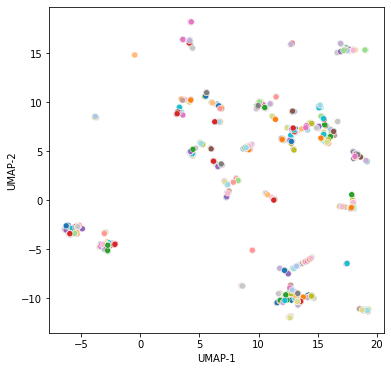

In [23]:
clusters = plot_clustering(similarity, None, 0.05, hl_umap)

In [30]:
clusters.max()

1225

Most clusters only contain 1 sequence.

## Sanity check
If two sequences ave at least 95% similarity, they should be in the same cluster.

In [26]:
def similar_sequences(seq_row, index, threshold=0.95):
    selected = seq_row[seq_row > threshold].index
    for other in selected:
        if clusters[index] != clusters[int(other)]:
            return False
    return True

In [27]:
checked = similarity.apply(lambda x: similar_sequences(x, x.name), axis=1)

In [28]:
checked.sum()

1551

## Clustering with a lower threshold

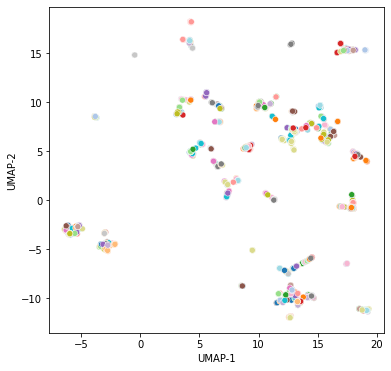

In [24]:
clusters = plot_clustering(similarity, None, 0.1, hl_umap)

In [25]:
clusters.max()

932

There are fewer clusters here, still average size is below 2. Let's use this clustering.
## Define datasets using clustering

In [29]:
cluster_assignment = {}
for i, cl in enumerate(clusters):
    cluster_assignment[cl] = cluster_assignment.get(cl, []) + [i]

In [30]:
train_indices, test_indices = train_test_split(range(clusters.max()), test_size=0.2, random_state=42)

In [15]:
test_indices, valid_indices = train_test_split(test_indices, test_size=0.5, random_state=46)

In [16]:
train_set = []
for idx in train_indices:
    train_set += cluster_assignment[idx + 1]
len(train_set)

1338

In [17]:
valid_set = []
for idx in valid_indices:
    valid_set += cluster_assignment[idx + 1]
len(valid_set)

120

In [18]:
test_set = []
for idx in test_indices:
    test_set += cluster_assignment[idx + 1]
len(test_set)

119

In [42]:
chen_train = chen_data.iloc[train_set]
chen_train

,Antibody_ID,heavy,light,Y
2073,6aod,EVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLE...,DIVMTKSPSSLSASVGDRVTITCRASQGIRNDLGWYQQKPGKAPKR...,0
1517,4yny,EVQLVESGGGLVQPGRSLKLSCAASGFTFSNYGMAWVRQTPTKGLE...,EFVLTQPNSVSTNLGSTVKLSCKRSTGNIGSNYVNWYQQHEGRSPT...,1
2025,5xcv,EVQLVESGGGLVQPGRSLKLSCAASGFTFSNYGMAWVRQTPTKGLE...,QFVLTQPNSVSTNLGSTVKLSCKRSTGNIGSNYVNWYQQHEGRSPT...,1
2070,6and,EVQLVESGGGLVQPGGSLRLSCAASGYEFSRSWMNWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRSSQSIVHSVGNTFLEWYQQKPG...,1
666,2xqy,QVQLQQPGAELVKPGASVKMSCKASGYSFTSYWMNWVKQRPGRGLE...,DIVLTQSPASLALSLGQRATISCRASKSVSTSGYSYMYWYQQKPGQ...,0
...,...,...,...,...
1080,4buh,EVQLVQSGAEVKKPGESLKISCKGSEYSFPNYWIAWVRQMPGKGLE...,SYELTQPPSASGTPGQRVTISCSGSSSNIGGNTVNWYQQVPGTAPR...,0
2296,6jbt,QGQLVQSGAEVKKPGASVKVSCKASGYTFTDYEMHWVRQAPIHGLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSIVHSNGNTYLEWYLQKPG...,0
202,1kc5,QVKLQQSGPGLVKPSQSLSLTCTVTGYSITSDYAWNWIRQFPGNKL...,DIVLTQSPKSMSMSVGEKVTLSCKASENVDTYVSWYQQRPEQPPAL...,0
203,1kcr,QVALQESGPGLVKPSQSLSLTCTVTGYSITSDYAWNWIRQFPGNKL...,DIVLTQSPKSMSMSVGERVTLSCKASENVGTYVSWYQQKPEQSPKL...,1


In [43]:
chen_train.to_csv(path.join(DATA_DIR, "chen/deduplicated/chen_train_data.csv"))

In [20]:
chen_train = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_train_data.csv"), index_col=0)

In [44]:
chen_valid = chen_data.iloc[valid_set]
chen_valid

,Antibody_ID,heavy,light,Y
2169,6ct7,EVQLVESGGGLVEPGGSLRLSCAVSGFDFEKAWMSWVRQAPGQGLQ...,SYELTQPPSVSVSPGQTARITCSGEALPMQFAHWYQQRPGKAPVIV...,0
1342,4nzu,AVSLVESGGGTVEPGSTLRLSCAASGFTFGSYAFHWVRQAPGDGLE...,DIEMTQSPSSLSASTGDKVTITCQASQDIAKFLDWYQQRPGKTPKL...,0
1728,5i8c,QEVLVQSGAEVKKPGASVKVSCRAFGYTFTGNALHWVRQAPGQGLE...,DIQLTQSPSFLSASVGDKVTITCRASQGVRNELAWYQQKPGKAPNL...,1
1729,5i8e,QEVLVQSGAEVKKPGASVKVSCRAFGYTFTGNALHWVRQAPGQGLE...,IQLTQSPSFLSASVGDKVTITCRASQGVRNELAWYQQKPGKAPNLL...,0
2114,6bb4,QVQLQQSDAELVKPGASVKISCKASGYTFTDRTIHWVKQRPEQGLE...,DVQMIQSPSSLSASLGDIVTMTCQASQDTSINLNWFQQKPGKAPKL...,0
...,...,...,...,...
1068,43c9,QVQLVESGPGLVAPSQSLSITCTVSGISLSRYNVHWVRQSPGKGLE...,DVVMTQTPSSLAMSVGQKVTMSCKSSQSLLNISNQKNYLAWYQQKP...,0
1872,5t5f,QVQMQQPGAELVKPGASVKLSCKASGYTFISYWMHWVKQRPGRGLE...,DIVMTQAAPSVPVTPGESVSISCRSSKSLLHSNGNTYLFWFLQRPG...,0
544,2gsi,VQLQQSGAELVRSGASVKLSCTASGFNIKDYYMYWVKLRPEQGLEW...,DIVLTQSPASLAVSLGQPATISCGASKSVRTSGYSYMDWNQQKPGQ...,0
611,2pcp,EVQLQQSGPELVKPGASVKMSCKASGYTFTDYYIHWNKQSHGKSLE...,DVLMTQTPLSLPVSLGDQASISCRSSQTIVHSNGNTYLEWYLQKPG...,0


In [45]:
chen_valid.to_csv(path.join(DATA_DIR, "chen/deduplicated/chen_valid_data.csv"))

In [21]:
chen_valid = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_valid_data.csv"), index_col=0)

In [46]:
chen_test = chen_data.iloc[test_set]
chen_test

,Antibody_ID,heavy,light,Y
2372,6obd,EVQLVESGGGLVQPGGSLRLSCAASGFPFSNYWMNWVRQAPGKGLE...,DIVMTQTPLSLSVTPGQPASISCKSSQSLLYSNGKTYLNWVLQKPG...,0
359,1sm3,QVQLQESGGGLVQPGGSMKLSCVASGFTFSNYWMNWVRQSPEKGLE...,DIVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0
1539,5a2i,QVQLQESGGGLVQPGGSMKLSCVASGFTFSNYWMNWVRQSPEKGLE...,DIVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0
1112,4f33,EVQLQQSGPELEKPGASVKISCKASGYSFTGYTMNWVKQSHGKSLE...,DIELTQSPAIMSASPGEKVTMTCSASSSVSYMHWYQQKSGTSPKRW...,1
314,1q1j,EVQLVESGGGLVKPGGSLRLTCVASGFTFSDVWLNWVRQAPGKGLE...,QSVLTQPPSVSAAPGQKVTISCSGSSSNIGNNYVLWYQQFPGTAPK...,0
...,...,...,...,...
545,2h1p,DVKLVESGGGLVKLGGSLKLSCAASGFTFSSYFLSWVRQTPEKRLE...,DVVMTQTPLSLPVSLGDPASISCRSSQSLVHSNGNTYLHWYLQKPG...,0
1162,4hdi,DVKLVESGGGLVKLGGSLKLSCAASGFTFSNYFMSWVRQTPEKRLE...,DVVMTQTPLSLPVSLGDQASISCRSSQSLVHSNGNTYLHWYLQKPG...,0
2404,6s5a,EVKLLESGGGLVQPGGSLKLSCAASGFDFSRYWMNWVRQAPGKGLE...,QAVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0
1684,5gkr,QVQLQESGPGLVKSSETLSLTCTVSGGSISSYFWSWIRQPPGKGLE...,QSALTQPRSVSGSPGQSVTISCTGTSSDVGGYNYVSWYQQHPGKAP...,1


In [47]:
chen_test.to_csv(path.join(DATA_DIR, "chen/deduplicated/chen_test_data.csv"))

In [22]:
chen_test = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_test_data.csv"), index_col=0)

# 5x2 cv

In [56]:
seeds = [13, 19, 27, 38, 42]

In [63]:
chen_data = chen_data.merge(clusters.rename("cluster"), left_index=True, right_index=True)

In [64]:
for seed in seeds:
    train_indices, test_indices = train_test_split(range(clusters.max()), test_size=0.5, random_state=seed)
    train_set = []
    for idx in train_indices:
        train_set += cluster_assignment[idx + 1]
    test_set = []
    for idx in test_indices:
        test_set += cluster_assignment[idx + 1]
    chen_train = chen_data.iloc[train_set]
    chen_train.to_csv(path.join(DATA_DIR, f"chen/deduplicated/crossval/chen_train_{seed}.csv"))
    chen_test = chen_data.iloc[test_set]
    chen_test.to_csv(path.join(DATA_DIR, f"chen/deduplicated/crossval/chen_test_{seed}.csv"))

In [54]:
train_set = []
for idx in train_indices:
    train_set += cluster_assignment[idx + 1]
len(train_set)

781

In [55]:
test_set = []
for idx in test_indices:
    test_set += cluster_assignment[idx + 1]
len(test_set)

770

In [ ]:
chen_train = chen_data.iloc[train_set]
chen_train.to_csv(path.join(DATA_DIR, "chen/deduplicated/chen_train_data.csv"))

In [ ]:
chen_test = chen_data.iloc[test_set]
chen_test.to_csv(path.join(DATA_DIR, "chen/deduplicated/chen_test_data.csv"))

## Check that the intersection of sets is empty

In [23]:
pd.merge(chen_train, chen_test, how='inner')

,Antibody_ID,heavy,light,Y


In [24]:
pd.merge(chen_train, chen_valid, how='inner')

,Antibody_ID,heavy,light,Y


In [25]:
pd.merge(chen_valid, chen_test, how='inner')

,Antibody_ID,heavy,light,Y


## Measure between-group similarity

In [58]:
train_valid = pd.concat([chen_valid, chen_train])

In [56]:
del(test_valid)

In [63]:
between_group_similarities = similarity.loc[train_valid.index][[str(num) for num in chen_test.index]]

In [65]:
between_group_similarities.max().max()

0.8999999999999999

In [66]:
between_group_similarities.min().min()

0.134

The maximum similarity of sequences in the train and test set is 0.89, as expected thanks to the distance cutoff of 0.1.

# Labels

In [35]:
chen_train = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_train_data.csv"), index_col=0)
chen_valid = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_valid_data.csv"), index_col=0)
chen_test = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_test_data.csv"), index_col=0)

In [15]:
tap_data = pd.read_csv(path.join(DATA_DIR, "tap/TAP_data.csv"))

In [6]:
chen_train["Y"].value_counts()

0    1057
1     281
Name: Y, dtype: int64

In [16]:
tap_data["Y"].value_counts()

1    231
0     10
Name: Y, dtype: int64

In [ ]:
fig, ax = plt.subplots()
ax.barh(y_pos, performance, xerr=error, align='center')

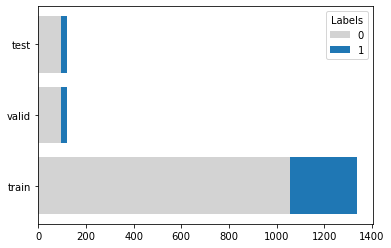

In [20]:
sets = ["train", "valid", "test"]
zeros = [chen_train["Y"].value_counts()[0], chen_valid["Y"].value_counts()[0], chen_test["Y"].value_counts()[0]]
ones = [chen_train["Y"].value_counts()[1], chen_valid["Y"].value_counts()[1], chen_test["Y"].value_counts()[1]]

b1 = plt.barh(sets, zeros, color="lightgray")
b2 = plt.barh(sets, ones, left=zeros, color='#1f77b4')

plt.legend([b1, b2], ["0", "1"], title="Labels", loc="upper right")
plt.savefig(path.join(DATA_DIR, "images/label_numbers_chen_split.png"))

plt.show()

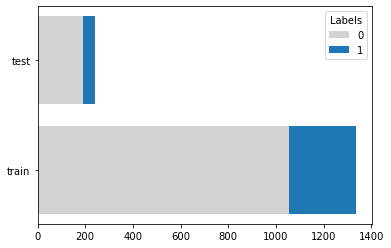

In [21]:
sets = ["train", "test"]
zeros = [chen_train["Y"].value_counts()[0], chen_valid["Y"].value_counts()[0] + chen_test["Y"].value_counts()[0]]
ones = [chen_train["Y"].value_counts()[1], chen_valid["Y"].value_counts()[1] + chen_test["Y"].value_counts()[1]]

b1 = plt.barh(sets, zeros, color="lightgray")
b2 = plt.barh(sets, ones, left=zeros, color='#1f77b4')

plt.legend([b1, b2], ["0", "1"], title="Labels", loc="upper right")

plt.show()

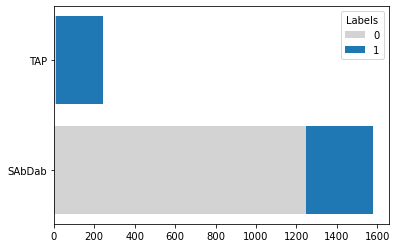

In [19]:
sets = ["SAbDab", "TAP"]
zeros = [chen_train["Y"].value_counts()[0] + chen_valid["Y"].value_counts()[0] + chen_test["Y"].value_counts()[0], tap_data["Y"].value_counts()[0]]
ones = [chen_train["Y"].value_counts()[1] + chen_valid["Y"].value_counts()[1] + chen_test["Y"].value_counts()[1], tap_data["Y"].value_counts()[1]]

b1 = plt.barh(sets, zeros, color="lightgray")
b2 = plt.barh(sets, ones, left=zeros, color='#1f77b4')

plt.legend([b1, b2], ["0", "1"], title="Labels", loc="upper right")

plt.savefig(path.join(DATA_DIR, "images/label_numbers_total.png"))
plt.show()

In [30]:
281 / (1057+281)

0.2100149476831091

In [28]:
chen_valid["Y"].value_counts()

0    94
1    26
Name: Y, dtype: int64

In [31]:
26 / (94+26)

0.21666666666666667

In [29]:
chen_test["Y"].value_counts()

0    96
1    23
Name: Y, dtype: int64

In [32]:
23 / (23+96)

0.19327731092436976

In [37]:
chen_all = pd.concat([chen_train, chen_valid, chen_test])
chen_all["heavy_length"] = chen_all["heavy"].str.len()
chen_all["light_length"] = chen_all["light"].str.len()

In [38]:
chen_all

,Antibody_ID,heavy,light,Y,heavy_length,light_length
2073,6aod,EVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLE...,DIVMTKSPSSLSASVGDRVTITCRASQGIRNDLGWYQQKPGKAPKR...,0,117,107
1517,4yny,EVQLVESGGGLVQPGRSLKLSCAASGFTFSNYGMAWVRQTPTKGLE...,EFVLTQPNSVSTNLGSTVKLSCKRSTGNIGSNYVNWYQQHEGRSPT...,1,117,109
2025,5xcv,EVQLVESGGGLVQPGRSLKLSCAASGFTFSNYGMAWVRQTPTKGLE...,QFVLTQPNSVSTNLGSTVKLSCKRSTGNIGSNYVNWYQQHEGRSPT...,1,117,109
2070,6and,EVQLVESGGGLVQPGGSLRLSCAASGYEFSRSWMNWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRSSQSIVHSVGNTFLEWYQQKPG...,1,120,112
666,2xqy,QVQLQQPGAELVKPGASVKMSCKASGYSFTSYWMNWVKQRPGRGLE...,DIVLTQSPASLALSLGQRATISCRASKSVSTSGYSYMYWYQQKPGQ...,0,118,111
...,...,...,...,...,...,...
545,2h1p,DVKLVESGGGLVKLGGSLKLSCAASGFTFSSYFLSWVRQTPEKRLE...,DVVMTQTPLSLPVSLGDPASISCRSSQSLVHSNGNTYLHWYLQKPG...,0,120,112
1162,4hdi,DVKLVESGGGLVKLGGSLKLSCAASGFTFSNYFMSWVRQTPEKRLE...,DVVMTQTPLSLPVSLGDQASISCRSSQSLVHSNGNTYLHWYLQKPG...,0,120,112
2404,6s5a,EVKLLESGGGLVQPGGSLKLSCAASGFDFSRYWMNWVRQAPGKGLE...,QAVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0,119,109
1684,5gkr,QVQLQESGPGLVKSSETLSLTCTVSGGSISSYFWSWIRQPPGKGLE...,QSALTQPRSVSGSPGQSVTISCTGTSSDVGGYNYVSWYQQHPGKAP...,1,116,110


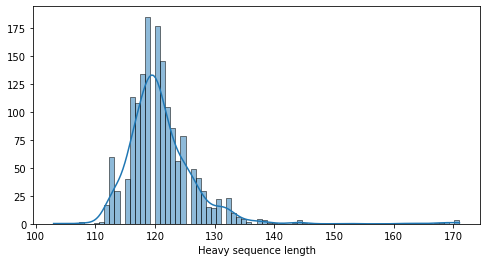

In [89]:
plt.figure(figsize=(8, 4))
ax = sns.histplot(data=chen_all, x="heavy_length", kde=True)
ax.set(xlabel='Heavy sequence length', ylabel='')
plt.savefig(path.join(DATA_DIR, "images/sequence_lengths_heavy.png"))
plt.show()

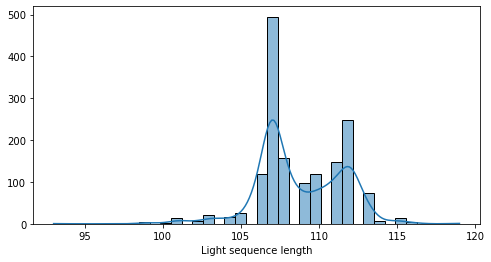

In [90]:
plt.figure(figsize=(8, 4))
ax = sns.histplot(data=chen_all, x="light_length", kde=True)
ax.set(xlabel='Light sequence length', ylabel='')
plt.savefig(path.join(DATA_DIR, "images/sequence_lengths_light.png"))
plt.show()

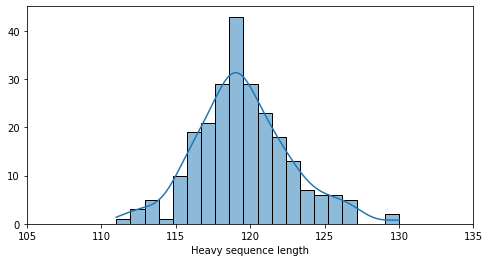

In [91]:
tap_data["heavy_length"] = tap_data["heavy"].str.len().astype(int)
tap_data["light_length"] = tap_data["light"].str.len()

plt.figure(figsize=(8, 4))
ax = sns.histplot(data=tap_data, x="heavy_length", kde=True)
ax.set(xlabel='Heavy sequence length', ylabel='')
ax.set_xlim(105, 135)
plt.savefig(path.join(DATA_DIR, "images/tap_sequence_lengths_heavy.png"))
plt.show()

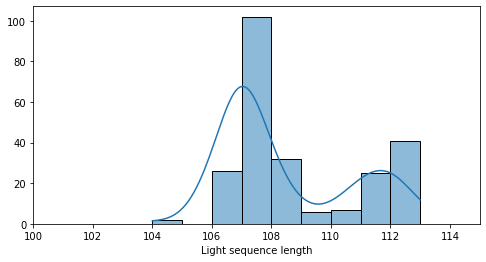

In [92]:
plt.figure(figsize=(8, 4))
ax = sns.histplot(data=tap_data, x="light_length", kde=True)
ax.set(xlabel='Light sequence length', ylabel='')
ax.set_xlim(100, 115)
plt.savefig(path.join(DATA_DIR, "images/tap_sequence_lengths_light.png"))
plt.show()

In [69]:
chen_all[chen_all["heavy_length"] > 150]

,Antibody_ID,heavy,light,Y,heavy_length,light_length
1752,5ilt,QVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPEKALE...,QAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,1,169,110
1749,5ijv,QVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALE...,QAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,1,152,110
1237,4k3e,EVQLRESGPSLVQPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALE...,EAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,1,164,110
2217,6e9h,QVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALE...,EAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,1,171,110
2218,6e9i,QVQLRESGPSLVKPSQTLSLTCTASGLSLSDKAVGWVRQAPGKALE...,EAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,0,168,110
2219,6e9k,QVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALE...,EAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,1,162,110
2220,6e9u,QVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALE...,EAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,0,171,110
1631,5e99,QVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALE...,QAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,1,171,110
1236,4k3d,EVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALE...,EAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,0,169,110
2216,6e9g,QVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALE...,EAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPR...,1,167,110


In [73]:
chen_all.loc[1631]["heavy"]

'QVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALEWLGSIDTGGTAGYNPGLKTRLSITKDNSKSQVSLTVSSVATEDSATYYCVTVYQKTTQKKNCPDDYTECYGGACDGTGCCSGSCGGASACRDWWPYRSICSSDNTYTYEFHVDAWGQGLLVTVSS'

In [74]:
chen_all.loc[1631]["light"]

'QAVLNQPSSVSGSLGQRVSITCSGSSSNVGNGYVSWYQLIPGSAPRTLIYGDTSRASGVPDRFSGSRSGNTATLTISSLQAEDEADYFCASAEDSSSNAVFGSGTTLTVL'

In [72]:
len("QVQLRESGPSLVKPSQTLSLTCTASGFSLSDKAVGWVRQAPGKALEWLGSIDTGGNAGYNPGLKSRLSITQDNSKSQVSLSVSTVTTEDSATYYCTTVHQRTKTTKSCPDGYSDGYRCGWRRSYCGDRNCCRVDGYTSYGGTGNCASYSYTYTYEWYVDAWGQGLLVTVSS")

171

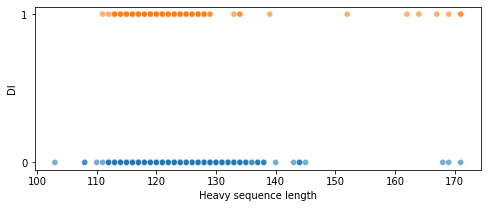

In [87]:
plt.figure(figsize=(8,3))
ax = sns.scatterplot(
        x="heavy_length", y="Y",
        hue="Y",
        data=chen_all,
        alpha=0.6,
        legend=None
    )
ax.set(xlabel='Heavy sequence length', ylabel='')
ax.set_yticks([0,1])
ax.set_ylabel("DI")
plt.savefig(path.join(DATA_DIR, "images/heavy_length_vs_di.png"), bbox_inches='tight')
plt.show()

# Filter by CDRH3 length

In [14]:
cdrh3 = heavy_df.merge(chen_data["Antibody_ID"], left_on="Ab_ID", right_on="Antibody_ID").iloc[:,131:196]
len(cdrh3)

1577

In [13]:
def is_aa(letter):
    if letter == "-":
        return 0
    else:
        return 1

def cdr_length(row):
    length = sum(is_aa(letter) for letter in row)
    return length

In [15]:
cdrh3_length = cdrh3.apply(cdr_length, axis=1)

In [33]:
chen_data["cdrh3_length"] = list(cdrh3_length)

In [34]:
chen_data_filtered = chen_data[chen_data["cdrh3_length"] < 27]

In [35]:
chen_data_filtered

,Antibody_ID,heavy,light,Y,cdrh3_length
0,12e8,EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLE...,DIVMTQSQKFMSTSVGDRVSITCKASQNVGTAVAWYQQKPGQSPKL...,0,13
1,15c8,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0,12
2,1a0q,EVQLQESDAELVKPGASVKISCKASGYTFTDHVIHWVKQKPEQGLE...,DIELTQSPSSLSASLGGKVTITCKASQDIKKYIGWYQHKPGKQPRL...,1,12
3,1a14,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,0,15
4,1a2y,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,0,10
...,...,...,...,...,...
2404,6s5a,EVKLLESGGGLVQPGGSLKLSCAASGFDFSRYWMNWVRQAPGKGLE...,QAVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0,12
2405,6tyb,EVQLVQSGTEVKRPGESLTISCKTSGYSFSGTWISWVRQMPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQGISTYLAWYQQKPGKAPKL...,0,19
2406,6u1t,EVQLVESGGGLVKPGGSLKLSCAASGFTFSSYDMSWVRQTPEKRLE...,DIQMTQSPASQSASLGESVTITCLASQTIGTWLAWYQQKPGKSPQL...,0,11
2407,7fab,AVQLEQSGPGLVRPSQTLSLTCTVSGTSFDDYYWTWVRQPPGRGLE...,ASVLTQPPSVSGAPGQRVTISCTGSSSNIGAGHNVKWYQQLPGTAP...,0,11


In [37]:
chen_data_filtered.to_csv(path.join(DATA_DIR, "chen/deduplicated/filtered_chen_data.csv"))